# Tutorial. The Fourier interpolation

Spectral methods are a class of spatial discretisation methods for differential equations in which the approximation of the solution $u$ of the problem is based an expansion in terms of so-called *trial functions* $\{\phi_k\}_{k=0,\dots,N-1}$,
$$
u(x)\approx\sum_{k=0}^{N-1}\tilde{u}_k\phi_k(x),
$$
the $N$ coefficients of the expansion being noted by $\tilde{u}_k$, $k=0,\dots,N-1$.

The choice of the trial function is dictated by the practical and computational efficiency of of the numerical method, and it has to meet the following requirements:
* *Convergence:* the approximation should converge rapidly to the solution $u$ as $N$ tends to $+\infty$,
* *Transformation:* the computation of the coefficients $\tilde{u}_k$ from the values of $u$ and the reconstruction of the function values at given nodes from the set of coefficients should be computationally fast,
* *Differentiation:* given the expansion coefficients of a function, it should be easy to determine the set of coefficients associated with an approximation of a spatial derivative of the function.

For periodic problems, the Fourier system, formed by the orthogonal (with respect to the $L^2((0,2\pi),\mathbb{C})$-scalar product) set of functions
$$
\forall k\in\mathbb{Z},\ \phi_k(x)=e^{ikx}
$$
over the interval $(0,2\pi)$ is an appropriate choice, due to the approximation properties of the Fourier series and the availability of a rapid algorithm, the [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform), to compute the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) of a sequence. The interpolant of $u$ then takes the form
$$
\sum_{k=-K}^K\tilde{u}_k\phi_k
$$
if $N=2K+1$ is odd, or
$$
\sum_{k=-K+1}^K\tilde{u}_k\phi_k
$$
if $N=2K$ is even, where the coefficients $\tilde{u}_k$ are the *discrete Fourier coefficients* of the function $u$.

The present notebook aims at investigating some computational and numerical aspects of the Fourier interpolation of a periodic function. 

The <tt>numpy</tt> and <tt>matplotlib</tt> packages will be needed.

In [1]:
import numpy as np

# To draw matplotlib plots within this notebook.
%matplotlib inline
import matplotlib.pyplot as plt
from python_code.nord_cmap import * 
from tqdm import tqdm
from typing import Iterable, Callable


## Exercise 1. The Fourier interpolation using the fast Fourier transform.

Consider an *even* non-zero natural integer $N$ and the set of $N$ equispaced points in the interval (chosen for convenience) $[0,2\pi]$
$$
x_j=\frac{2\pi j}{N},\ j=0,\dots,N-1.
$$
Given a periodic function $u$, the *$\frac{N}{2}$-degree trigonometric interpolant of $u$ at the nodes $x_j$*, $j=0,\dots,N-1$, is
$$
I_Nu(x)=\frac{1}{N}\sum_{k=-N/2+1}^{N/2}\tilde{u}_k\,e^{ikx},
$$
the discrete Fourier coefficients in the expansion being given by
$$
\tilde{u}_k=\sum_{j=0}^{N-1}u(x_j)\,e^{-ikx_j},\ k=-\frac{N}{2}+1,\dots,\frac{N}{2}.
$$
The determination of the interpolant is directly related to the computation of its coefficients, which can be accomplished by the [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) (FFT) algorithm, available in the `fft` library of <tt>numpy</tt> (see the [documentation](https://numpy.org/doc/stable/reference/routines.fft.html)). The computational complexity of this algorithm is $O(N\log_2(N))$.

**Question.** Write a function computing the expansion coefficients of the interpolant $I_Nu$ of a function $u$, the function and the integer $N$ being given. The complexity of this function should be a $O(N\log_2(N))$.

In [2]:
def fft(u : Callable, N : int) -> Iterable : 
    
    """fft compute expansion coefficients of the interpolant of u

    Parameters
    ----------
    u : Callable
        function to be interpolated
    N : int
        set the N equispaced points in the interval [0, 2pi]; Must be a power of 2 

    Returns
    -------
    Iterable
        array of expansion coefficients     
    """    
    
    X = np.arange(0, N) * np.pi * 2 / N 
    U = u(X).astype(complex)

    def Cooley_tukey(x) : 
        
            N = len(x)
            
            if N == 1:
                return x
            else:
                
                X_even = Cooley_tukey(x[::2])
                X_odd = Cooley_tukey(x[1::2])
                factor = \
                np.exp(-2j*np.pi*np.arange(N)/ N)
                
                X = np.concatenate(\
                    [X_even+factor[:int(N/2)]*X_odd,
                    X_even+factor[int(N/2):]*X_odd])
                
                return X
                    
    U = Cooley_tukey(U)
    
    return U

**Question.** Write a function which evaluates the interpolant $I_Nu$ of a function $u$ at a given set of points, the set of discrete Fourier coefficients being given.

In [7]:
def interpolant_fft(u : Callable,set_points : Iterable, N : int = 256 ) : 
    
    """
    interpolant_fft compute the fourier interpolant of a function u

    Parameters
    ----------
    u : Callable
        function to be interpolated
    set_points : Iterable
        points to interpolate
    N : int, optional
        number of points to build expansion coefficients , by default 256

    Returns
    -------
    _type_
        _description_
    """    
    
    expansion_coeffs = np.fft.fft(u(np.linspace(0,np.pi *2, N,endpoint= False)))
    
    k = np.concatenate([np.arange(0,N//2 + 1), np.arange(-N//2 + 1, 0)])
    
    interpolant_approximation = np.empty_like(set_points, dtype= np.complex128)
    
    for j, x in enumerate(set_points): 
        
        interpolant_approximation[j] = 1/N * np.sum(expansion_coeffs * np.exp(1j * k * x))
        
    return interpolant_approximation
    

**Question.** Is the Fourier interpolant of a real function always real?

**Answer.**

**Question.** Use the written functions to plot and compare the graphs of the following functions of  $L^2([0,2\pi],\mathbb{R})$ and their respective interpolants, for several values of $N$,

* $u(x) = \cos(2x) + \sin(4x)$,
* $u(x) = \mathbb{1}_{\left[\frac{\pi}{2},\frac{3\pi}{2}\right]}(x)$,
* $u(x) = \sin (2x)\exp\left(\cos\left(8x\right)\right)$.
  
Is the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon) observed for one of these functions?

In [8]:
def u1(x) : return np.cos(2 * x) + np.sin(4 * x)

def u2(x) : 
    mask =  np.abs(x - np.pi) < np.pi / 2
    a = np.zeros_like(x)
    a[mask] = 1
    return a 

def u3(x) : return np.sin(2 * x) * np.exp(np.cos(8 * x))

/home/andrea/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


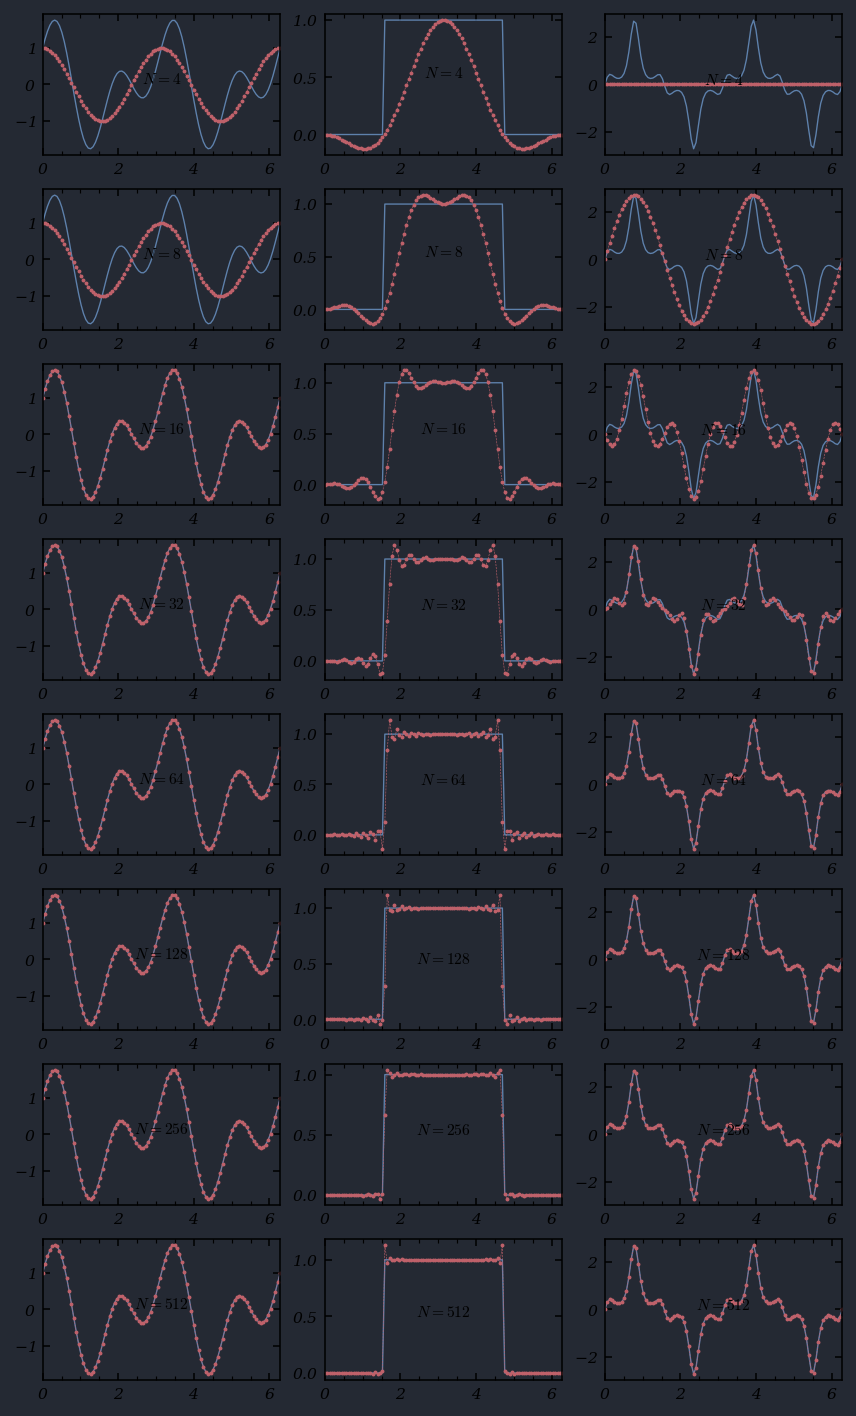

In [9]:
fig, ax = plt.subplots(8,3, figsize = (6,10))
Num = [2**k for k in range(2,10)]
x = np.linspace(0,2 * np.pi, 100)
functions = [u1, u2, u3]
color = color_list(2)
for j in range(len(Num)) : 
    for k in range(3) : 
        
        ax[j,k].plot(x, functions[k](x), lw = .7, color = color[0])
        ax[j,k].plot(x, interpolant_fft(functions[k],x, N = Num[j]),'--', lw = .3 , marker = '.', markersize = 2,color = color[1])
        ax[j,k].set_xlim(0, 2 * np.pi)
        ax[j,k].text(np.pi, np.mean(functions[k](x)), f"$N = {Num[j]}$", ha = 'center')

**Answer.**

## Exercise 2. The Fourier interpolation derivative.

The *Fourier interpolation derivative* of a function $u$ is defined as the derivative of the interpolant $I_Nu$, that is
$$
\mathcal{D}_Nu=(I_Nu)',
$$
and, using the previous definitions, one can write, for even non-zero natural integer $N$,
$$
\mathcal{D}_Nu(x)= \sum_{k=-N/2+1}^{N/2}{ik\tilde{u}_k e^{ikx}}.
$$
As a consequence, it is easy to compute the Fourier interpolation derivative of a function once the Fourier interpolant of this function is known. 

Note that, since interpolation and differentiation do not commute, one has in general
$$
(I_nu)'\neq I_N(u'),
$$
and one can then wonder if the interpolation derivative is a good approximation to $u'$.

**Question.** Write a function which computes the coefficients of the Fourier interpolation derivative $\mathcal{D}_Nu$ of a function $u$, the set of discrete Fourier coefficients of the interpolant $I_Nu$ being given.

In [10]:
def der_interpolant_coeff(u : Callable, N : int = 256) : 
    """
    der_interpolant_coeff compute the expansion 's coefficients of u'

    Parameters
    ----------
    u : Callable
        function to  be differenciated
    N : int, optional
        number of coefficients in the expansion, by default 256

    Returns
    -------
    _type_
        _description_
    """    
    expansion_coeffs = np.fft.fft(u(np.linspace(0,2 * np.pi, N, endpoint= False)))
    k = np.concatenate([np.arange(0,N/2 + 1), np.arange(-N/2 + 1, 0)])
    
    return 1j * k * expansion_coeffs
    
    

**Question.** Using the `np.fft.ifft` function for the inverse discrete Fourier transform, write a function which computes the values of the Fourier interpolation derivative $\mathcal{D}_Nu$ at the interpolation nodes, the disrete Fourier coefficients of $\mathcal{D}_Nu$ being given.

In [11]:
def der_interpolant(u : Callable, nodes : Iterable, N : int = 256) : 
        """
        der_interpolant compute the interpolation of u'

        Parameters
        ----------
        u : Callable
            function to  be differenciated and interpolated
        nodes : Iterable
            nodes on which the interpolation is made
        N : int, optional
            number of coefficients in the expansion, by default 256

        Returns
        -------
        _type_
            _description_
        """        
        D_coeff = der_interpolant_coeff(u, N)
        k = np.concatenate([np.arange(0,N/2 + 1), np.arange(-N/2 + 1, 0)])
        
        interpolation_der = np.empty_like(nodes, dtype= np.complex128)
    
        for j, x in enumerate(nodes): 
        
                interpolation_der[j] = 1/N * np.sum(D_coeff* np.exp(1j * k * x))
        
        return interpolation_der

**Question.** Compare the graphs of the derivatives the following periodic functions of $L^2([0,2\pi],\mathbb{R})$ with the values at the interpolation nodes of their respective Fourier interpolation derivatives, for several values of $N$,
* $u(x) = \cos(x) + \sin(2x)$,
* $u(x) = \mathbb{1}_{\left[\frac{\pi}{2},\frac{3\pi}{2}\right]}(x)$,
* $u(x) = \sin (2x)\exp\left(\cos\left(8x\right)\right)$.

In [12]:
def u_1(x) : return np.cos(x) + np.sin(2 * x)

def u_2(x) : 
    mask =  np.abs(x - np.pi) < np.pi / 2
    a = np.zeros_like(x)
    a[mask] = 1
    return a

def u_3(x) : return np.sin(2 * x) * np.exp(np.cos(8 * x))


In [13]:
def u1_p(x) : return -np.sin(x) + 2 * np.cos(2 * x)

def u2_p(x) : 
    return np.zeros_like(x)

def u3_p(x) : return np.exp(np.cos(8 * x)) * (2 * np.cos(2 * x)  - 8 * np.sin(2 * x) * np.sin(8 * x))

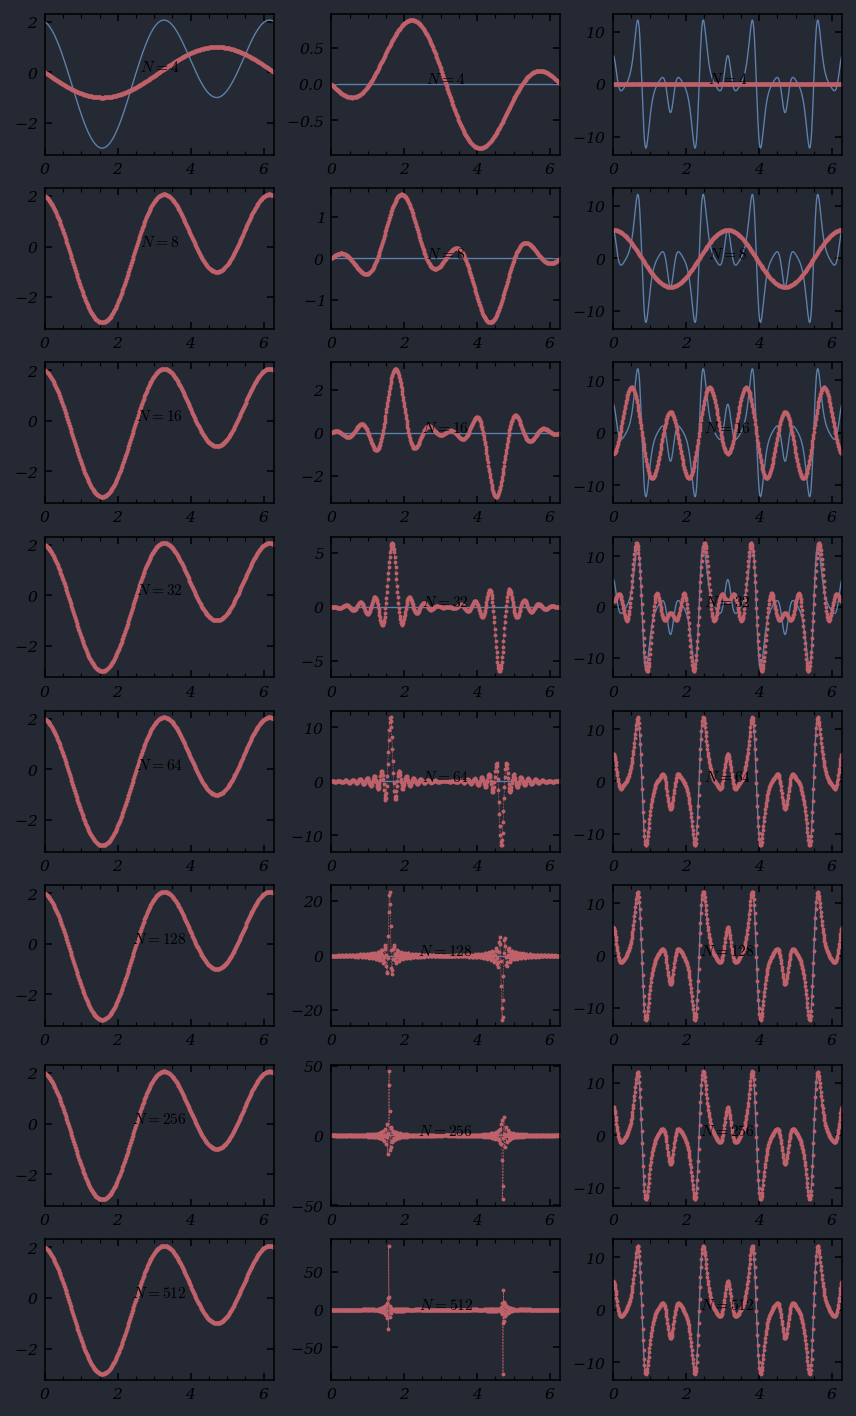

In [15]:
fig, ax = plt.subplots(8,3, figsize = (6,10))
Num = [2**k for k in range(2,10)]
x = np.linspace(0,2 * np.pi, 500)
functions = [u_1, u_2, u_3]
functions_p = [u1_p, u2_p, u3_p]
color = color_list(2)
for j in range(len(Num)) : 
    for k in range(3) : 
        
        ax[j,k].plot(x, functions_p[k](x), lw = .7, color = color[0])
        ax[j,k].plot(x, der_interpolant(functions[k],x, Num[j]) ,'--', lw = .3 , marker = '.', markersize = 2,color = color[1])
        ax[j,k].set_xlim(0, 2 * np.pi)
        ax[j,k].text(np.pi, np.mean(functions_p[k](x)), f"$N = {Num[j]}$", ha = 'center')

## Exercise 3. Aliasing on an example.

Aliasing effects are caused by the fact that the functions $\{e^{i(k+Nm)x}\}_{m\in\mathbb{Z}}$ are indistinguishable on the discrete grid $\{\frac{2\pi j}{N},\ j=0,\dots,N-1\}$ (in other words, they are *aliases* of one another). The code below illustrates this phenomenon, showing that the modes $e^{ix}$ and $e^{9ix}$ both have the same representation on the grid $\{\frac{\pi j}{4},\ j=0,\dots,7\}$.

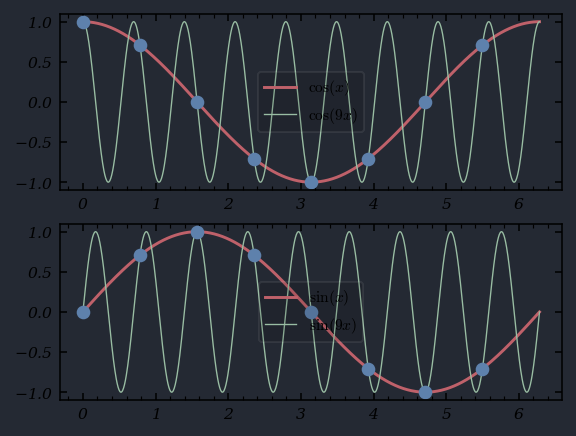

In [16]:
x=np.linspace(0,2*np.pi,8,endpoint=False)

y=np.linspace(0,2*np.pi,1000)
color = color_list(3)[::-1]
fig,axs=plt.subplots(2,1,figsize=(4,3))
axs[0].plot(y,np.cos(y),label=r'$\cos(x)$', color = color[0])
axs[0].plot(y,np.cos(9*y),lw = .7, label=r'$\cos(9x)$', color = color[1])
axs[0].plot(x,np.cos(x),'o', color = color[2])
axs[0].legend(loc = 'center')

axs[1].plot(y,np.sin(y),label=r'$\sin(x)$', color = color[0])
axs[1].plot(y,np.sin(9*y),lw = .7,label=r'$\sin(9x)$', color = color[1])
axs[1].plot(x,np.sin(x),'o', color = color[2])
axs[1].legend(loc = 'center')

Let us consider the following periodic functions of $L^2([0,2\pi],\mathbb{R})$:
* $u(x)=\cos(3x)$,
* $v(x)=\sin(4x)$,
* $s(x)=u(x)v(x)$.

**Question.** What is the Fourier series associated with the function $s$? What is the minimum value of $N$ such that $I_Ns=s$?

The fourier transform associated with s is : 

$$\begin{cases}
\tilde u_k = \frac{1}{2} \, \text{if } k \in \{1,7\} \\
\tilde u_k = 0 \, \text{else}

\end{cases}$$

Hence, We must have $N > 14$ to have $I_Ns=s$

**Answer.**

**Question.** Plot the graphs of the functions $u$, $v$ and $s$, and of their respective Fourier interpolants $I_Nu$, $I_Nv$ and $I_Ns$, on the same figures for $N=7,9,15$. Comment.

In [17]:
def u1(x) : return np.cos(3 * x)

def u2(x) : return np.sin(4 * x)

def u3(x) : return u1(x) * u2(x)

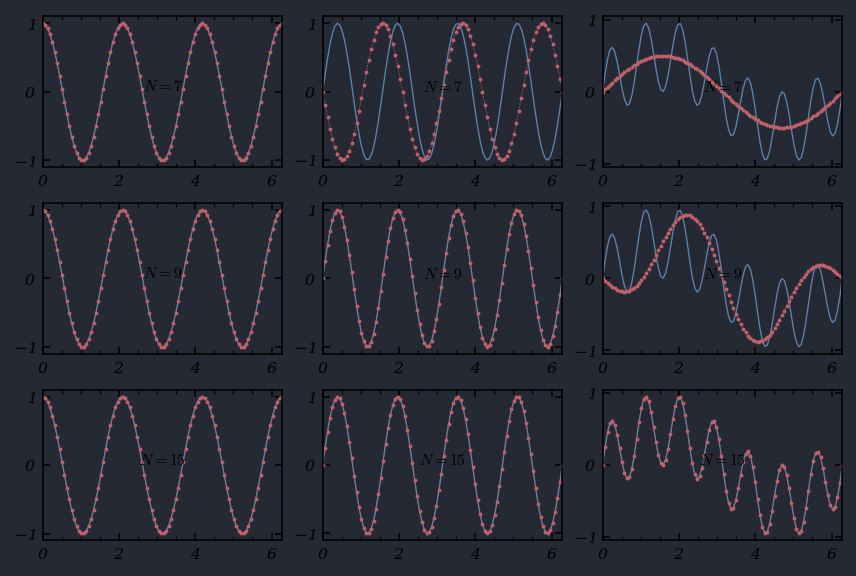

In [18]:
fig, ax = plt.subplots(3,3, figsize = (6,4))
Num = [7,9,15]
x = np.linspace(0,2 * np.pi, 100)
functions = [u1, u2, u3]
color = color_list(2)
for j in range(len(Num)) : 
    for k in range(3) : 
        
        ax[j,k].plot(x, functions[k](x), lw = .7, color = color[0])
        ax[j,k].plot(x, interpolant_fft(functions[k],x, N = Num[j]),'--', lw = .3 , marker = '.', markersize = 2,color = color[1])
        ax[j,k].set_xlim(0, 2 * np.pi)
        ax[j,k].text(np.pi, np.mean(functions[k](x)), f"$N = {Num[j]}$", ha = 'center')
        

**Answer.**

In spectral methods, aliasing appears when dealing with nonlinear terms involving products, due to wave numbers appearing in the convolution of functions exceeding the fixed range of wavenumbers, equal to $\lfloor\frac{N}{2}\rfloor$. More precisely, an approach to avoid convolutions in spectral space is to use the inverse discrete Fourier transform to compute products in the physical space and then use the discrete Fourier transform to return to spectral space, the resulting scheme being called a [*pseudo-spectral method*](https://en.wikipedia.org/wiki/Pseudo-spectral_method). As seen in the example above, this product contains modes with higher wavenumbers which may not be correctly represented on the discrete grid. These are then aliased to modes with lower wavenumbers, which may introduce notable errors in the method or even result in a numerical instability.

A cure to this effect is to use a grid fine enough to correctly resolve all the modes involved in the computations, but basic techniques for aliasing removal in quadratic nonlinearities have also been proposed in the literature, one of them being the *two-thirds rule* introduced by Orszag in a [very short note](https://doi.org/10.1175/1520-0469(1971)028%3C1074:OTEOAI%3E2.0.CO;2). It works as follows.

- Assuming the $N$ gridpoints are used, the two arrays storing the spectral coefficients of the functions to be multiplied are first extended to a larger size $M=\frac{3N}{2}$ (since $N=\frac{2M}{3}$, the number of de-aliased coefficients is two-thirds of the total number of coefficients, hence the name of the technique) and padded on both sides with zeros.
- Inverse discrete Fourier transforms are performed on the resulting arrays and the product is computed in the physical space.
- The discrete Fourier transform of the product is computed and the $M-N$ discrete Fourier coefficients corresponding to higher wavenumbers are dropped by truncation, while the remaining ones yield the de-aliased coefficients after multiplication by $\frac{3}{2}$.

Let us briefly explain the rationale behind such a choice for $M$. Let
$$
\forall j\in\{0,\dots,M-1\},\ y_j=\frac{2\pi j}{M},\ u_j=\frac{1}{M}\sum_{k=-M/2+1}^{M/2}\check{u}_ke^{iky_j},\ v_j=\frac{1}{M}\sum_{k=-M/2+1}^{M/2}\check{v}_ke^{iky_j},\ s_j=u_jv_j,
$$
where
$$
\forall k\in\left\{-\frac{M}{2}+1,\dots,\frac{M}{2}\right\},\ \check{u}_k=\begin{cases}\hat{u}_k&\text{if }-\frac{N}{2}+1\leq k\leq\frac{N}{2}\\0&\text{otherwise}\end{cases}\text{ and }\check{v}_k=\begin{cases}\hat{v}_k&\text{if }-\frac{N}{2}+1\leq k\leq\frac{N}{2}\\0&\text{otherwise}\end{cases},
$$
with $\hat{u}_k$ and $\hat{v}_k$, $k=-\frac{N}{2}+1,\dots,\frac{N}{2}$, the respective Fourier coefficients of $u$ and $v$.
Let
$$
\forall k\in\left\{-\frac{M}{2}+1,\dots,\frac{M}{2}\right\},\ \check{s}_k=\sum_{j=0}^{M}s_je^{-iky_j}.
$$
Then, one has
$$
\check{s}_k=\sum_{m+n=k}\check{u}_m\check{v}_n+\sum_{m+n=k\pm M}\check{u}_m\check{v}_n,
$$
and since we are only interested in the coefficients $\check{s}_k$ for which $k$ belongs to $\left\{-\frac{N}{2}+1,\dots,\frac{N}{2}\right\}$, we choose $M$ so that the second sum on the right-hand side, the *aliasing error*, vanishes for these indices. The coefficients $\check{u}_m$ and $\check{v}_m$ being zero for $m>\frac{N}{2}+1$ or $m<-\frac{N}{2}$, we demand that, for any $m$ and $n$ in $\left\{-\frac{N}{2}+1,\dots,\frac{N}{2}\right\}$,
$$
m+n-M<-\frac{N}{2}+1\text{ if }m+n>\frac{M}{2},
$$
or
$$
m+n+M>\frac{N}{2}\text{ if }m+n<-\frac{M}{2}+1.
$$
The worst-case condition is obtained for the choice $m=n=\frac{N}{2}$ in the first of these two cases, which gives
$$
M>\frac{3N}{2}-1.
$$
With $M$ chosen in this way, we have obtained the de-aliased coefficients of $s$, that is
$$
\forall k\in\left\{-\frac{N}{2}+1,\dots,\frac{N}{2}\right\},\ \check{s}_k=\hat{s}_k,
$$
where $\hat{s}_k=\sum_{m+n=k}\hat{u}_m\hat{v}_n$.

It has to be stressed that this method only helps to suppress aliasing errors and does not increase the resolution of the numerical solution. Note that the technique can be adapted to the case of the product of $p$ functions by setting $M=\frac{p+1}{2}N$.

**Question.** Implement the two-thirds rule algorithm computing the interpolation coefficients of the product of two functions, the respective sets of interpolation coefficients of the functions being given. Test it on the previous example.

In [19]:
def interpolant_fft(expansion_coeffs,set_points, N = 256) : 
    
    k = np.concatenate([np.arange(0,N//2 + 1), np.arange(-N//2 + 1, 0)])
    
    interpolant_approximation = np.empty_like(set_points, dtype= np.complex128)
    
    for j, x in enumerate(set_points): 

        interpolant_approximation[j] = 1/N * np.sum(expansion_coeffs * np.exp(1j * k * x))
        
    return interpolant_approximation

In [21]:
def Orsag_method(u : Callable,v : Callable, N : int): 
    """
    Orsag_method Compute the fft of u * v using two-thirds rule in order to de-aliased the expansion

    Parameters
    ----------
    u : Callable
        first function
    v : Callable
        second function
    N : int
        Number of coefficient in the expansion

    Returns
    -------
    _type_
        _description_
    """    
    
    x = np.linspace(0, 2 * np.pi, N, endpoint= False)
    U, V = np.fft.fft(u(x)) , np.fft.fft(v(x))
    M = 3 * N // 2
    # extending arrays of fft cefficients to the size M 
    U_, V_ = np.insert(U, N//2, np.zeros(N//2)), np.insert(V, N//2, np.zeros(N//2))
    u_tilde, v_tilde = np.fft.ifft(U_), np.fft.ifft(V_)    
    s = np.fft.fft(u_tilde * v_tilde)
    
    return 3/2 * np.concatenate([s[:N//2], s[N:]])

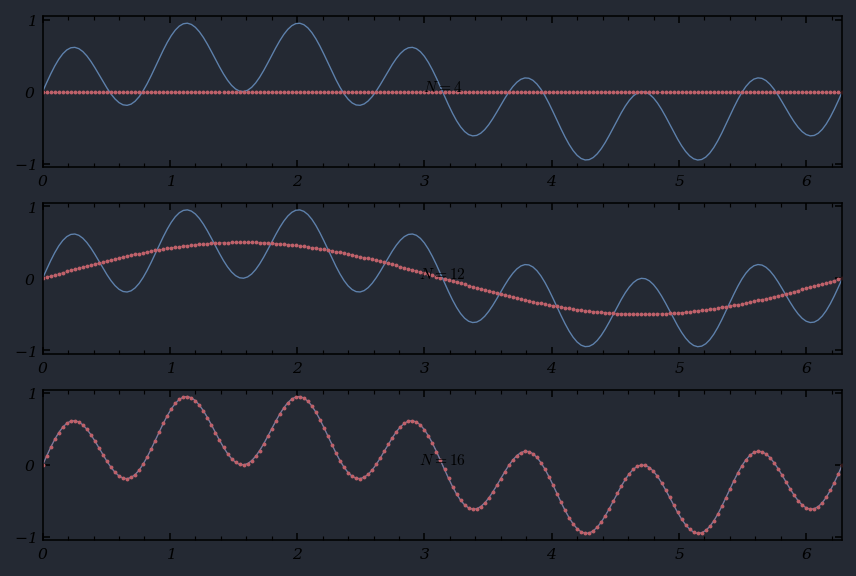

In [24]:
fig, ax = plt.subplots(3, figsize = (6,4))
Num = [4,12,16]
x = np.linspace(0,2 * np.pi, 200)
color = color_list(2)
for j in range(len(Num)) :
    
    ax[j].plot(x, u3(x), lw = .7, color = color[0])
    ax[j].plot(x, interpolant_fft(Orsag_method(u1,u2, Num[j]),x,N = Num[j]), '--', lw = .3 , marker = '.', markersize = 2,color = color[1])
    ax[j].set_xlim(0, 2 * np.pi)
    ax[j].text(np.pi, np.mean(u3(x)), f"$N = {Num[j]}$", ha = 'center')